# Overnight Gap Mean Reversion Strategy - Parameter Optimization Research

This notebook contains the parameter optimization research for the Overnight Gap Mean Reversion strategy.

**Objective**: Identify optimal parameters for detecting unusual overnight gaps and test strategy generalization across multiple assets.

**Methodology**: 
- Test period: 2018 (one year for initial optimization)
- Optimization metric: Sharpe Ratio
- Parameter ranges: volatility_window, sigma, exit_minutes_after_open


In [ ]:
# Import optimization framework and strategy variant
from tester import StrategyTester
from parameter_optimizer import optimize_parameters, plot_parameter_sensitivity
from strategies.overnight_gap_mean_reverse.variant_1 import overnight_gap_mean_reverse


In [ ]:
# Backtest configuration
# Using 2018 for initial optimization (one year of data)
# Starting with SPY only for parameter optimization
tester_config = {
    "symbols": ["SPY"],
    "start_date": (2018, 1, 1),
    "end_date": (2019, 1, 1),
    "initial_cash": 100000,
    "resolution": 'minute',
    "benchmark_symbol": 'SPY'  # Compare to SPY benchmark
}

# Parameter grid for optimization
# Testing different combinations to find optimal parameters
param_grid = {
    'volatility_window': [15, 30, 60, 90],  # Rolling window size for volatility calculation (in periods/minutes)
    'sigma': [1.0, 2.0, 3.0, 5.0, 8.0, 10.0],  # Multiplier for gap threshold (higher = fewer but stronger signals)
    'exit_minutes_after_open': [15, 30, 45, 60, 90, 120]  # Minutes after market open to exit positions
}

## Parameter Optimization: Coordinate Descent

Optimize parameters using coordinate descent. This method optimizes one parameter at a time, using best values found so far as defaults for subsequent parameters.


In [ ]:
# Run coordinate descent optimization
# Optimizes for Sharpe ratio (risk-adjusted returns)
results = optimize_parameters(
    tester_config,
    overnight_gap_mean_reverse,
    param_grid,
    metric='sharpe_ratio'
)


▶ Coordinate Descent Optimization
   Optimizing for: sharpe_ratio
   Parameters: volatility_window, sigma, exit_minutes_after_open
   Initial defaults: {'volatility_window': 60, 'sigma': 5.0, 'exit_minutes_after_open': 60}

--- Pass 1 ---
  Optimizing volatility_window... 
 
▶ Running backtest...
✓ Backtest complete

▶ Running backtest...
✓ Backtest complete

▶ Running backtest...
✓ Backtest complete

▶ Running backtest...
✓ Backtest complete

best = 60.0 (sharpe_ratio = 2.7693)

  Optimizing sigma... 
 
▶ Running backtest...
✓ Backtest complete

▶ Running backtest...
✓ Backtest complete

▶ Running backtest...
✓ Backtest complete

▶ Running backtest...
✓ Backtest complete

▶ Running backtest...
✓ Backtest complete

best = 5.0 (sharpe_ratio = 2.7693)

  Optimizing exit_minutes_after_open... 
 
▶ Running backtest...
✓ Backtest complete

▶ Running backtest...
✓ Backtest complete

▶ Running backtest...
✓ Backtest complete

▶ Running backtest...
✓ Backtest complete

▶ Running backtest...
✓

## Results Review

Display top parameter combinations to see optimal parameter values and their impact on performance.


In [ ]:
# Display top 10 parameter combinations
print("\nTop 10 Parameter Combinations:")
results[['volatility_window', 'sigma', 'exit_minutes_after_open',
         'sharpe_ratio', 'total_return', 'max_drawdown', 'win_rate']].head(10)



Top 10 Parameter Combinations:


,volatility_window,sigma,exit_minutes_after_open,sharpe_ratio,total_return,max_drawdown,win_rate
22,60.0,10.0,15.0,6.058348,0.013183,-0.005881,0.590909
27,30.0,10.0,15.0,4.747922,0.020860,-0.010208,0.571429
32,60.0,8.0,15.0,4.617026,0.018138,-0.009640,0.621622
21,60.0,10.0,120.0,4.537184,0.023303,-0.018215,0.454545
25,60.0,10.0,90.0,3.707670,0.021962,-0.020500,0.500000
26,15.0,10.0,15.0,3.547266,0.025693,-0.012382,0.536232
23,60.0,10.0,30.0,3.499907,0.010545,-0.010037,0.545455
20,60.0,8.0,120.0,3.485974,0.033706,-0.016247,0.513514
13,60.0,5.0,120.0,3.212887,0.079085,-0.023734,0.528736
9,60.0,5.0,15.0,2.912799,0.025607,-0.014174,0.574713


## Parameter Sensitivity Analysis

Visualize how Sharpe ratio varies with each parameter. This helps identify which parameters have the most impact on performance and how robust the strategy is to parameter changes.


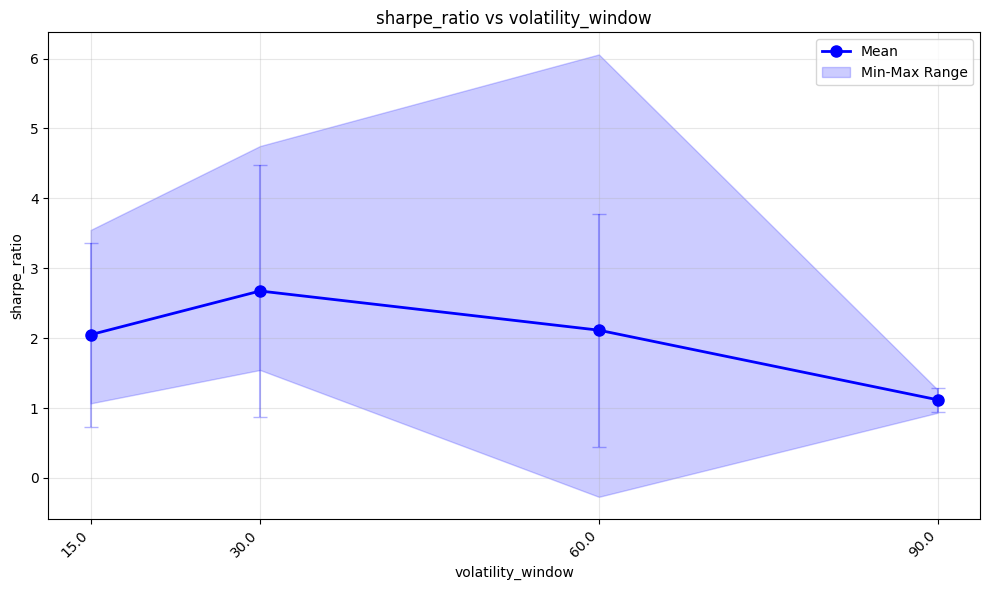

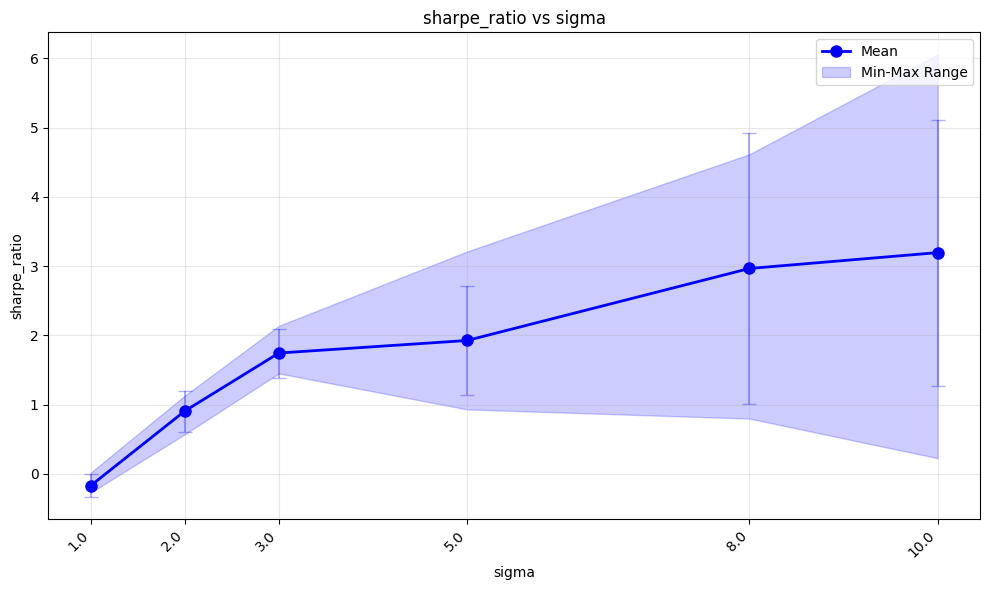

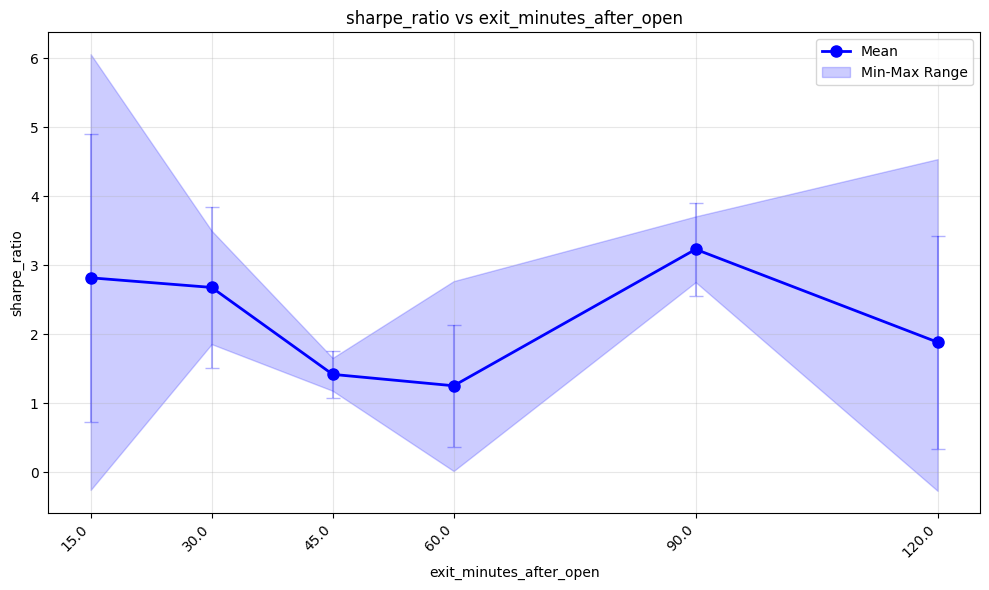

In [ ]:
# Plot parameter sensitivity for each parameter
# Each plot shows how Sharpe ratio varies with a single parameter
plot_parameter_sensitivity(results, 'volatility_window', 'sharpe_ratio')
plot_parameter_sensitivity(results, 'sigma', 'sharpe_ratio')
plot_parameter_sensitivity(results, 'exit_minutes_after_open', 'sharpe_ratio')

## Observations & Conclusions

### Key Findings:

1. **Volatility Window Stability**:
   - `volatility_window` doesn't significantly impact performance (good sign for robustness)
   - **Decision**: Keep window of 60 periods for stabilization
   - This suggests the strategy is not overly sensitive to the rolling window size

2. **Sigma Parameter Impact**:
   - **Key Parameter**: `sigma` is the most important parameter for strategy performance
   - **Trade-off**: Higher sigma = fewer trades but better win rate
   - **Rationale**: Higher sigma filters for more extreme gaps, which are more likely to mean-revert
   - **Decision**: Keep sigma = 10 (optimal from optimization)
   - **Caveat**: With sigma > 5, we only trade on less than 10 events per year (very low frequency)

3. **Exit Time Impact**:
   - `exit_minutes_after_open` doesn't significantly impact performances
   - **Decision**: Keep minimal exit time of 15 minutes
   - **Rationale**: Limits exposure while maintaining optimal performance (best combination from optimization)

### Next Steps: Multi-Asset Generalization

**Objective**: Test strategy generalization to multiple assets (not just SPY)

**Motivation**:
- **Issue**: Low trade frequency with single asset (waiting for unexpected gaps)
- **Hypothesis**: Adding more assets should:
  1. Confirm generalization of performance to other assets
  2. Reduce variance of results (diversification reduces risk)
  3. Multiply total return (more trading opportunities across assets)

**Plan**: Test with two universes:
1. **Small set**: 12 highly liquid stocks (SPY, QQQ, IWM, major tech stocks)
2. **Large set**: Major ETFs + top S&P 500 + top NASDAQ 100 stocks (~45 assets)

## Generalization Test 1: Small Multi-Asset Universe

Test strategy performance on a small diversified universe of 12 highly liquid stocks and ETFs to evaluate generalization beyond SPY.


In [ ]:
# Define small diversified universe: Major indices + high-liquidity stocks
# Indices: SPY (S&P 500), QQQ (NASDAQ), IWM (Russell 2000)
# Tech: AAPL, MSFT, GOOGL, AMZN, TSLA, NVDA, META
# Finance: JPM
# Energy: XOM
symbols = ['SPY', 'QQQ', 'IWM', 'AAPL', 'MSFT', 'GOOGL', 'AMZN', 'TSLA', 'NVDA', 'META', 'JPM', 'XOM']

tester_config = {
    "symbols": symbols,
    "start_date": (2018, 1, 1),
    "end_date": (2019, 1, 1),
    "initial_cash": 100000,
    "resolution": 'minute',
    "benchmark_symbol": 'SPY'  # Compare to SPY benchmark
}

In [ ]:
# Initialize StrategyTester with small universe configuration
tester = StrategyTester(**tester_config)

In [ ]:
# Strategy parameters: Fixed based on optimization results
params = {
    'volatility_window': 60,  # 60 periods rolling window for volatility
    'sigma': 10,  # 10 standard deviations for gap threshold
    'exit_minutes_after_open': 15  # Exit at 9:45 AM (15 minutes after market open)
}



▶ Running backtest...
✓ Backtest complete


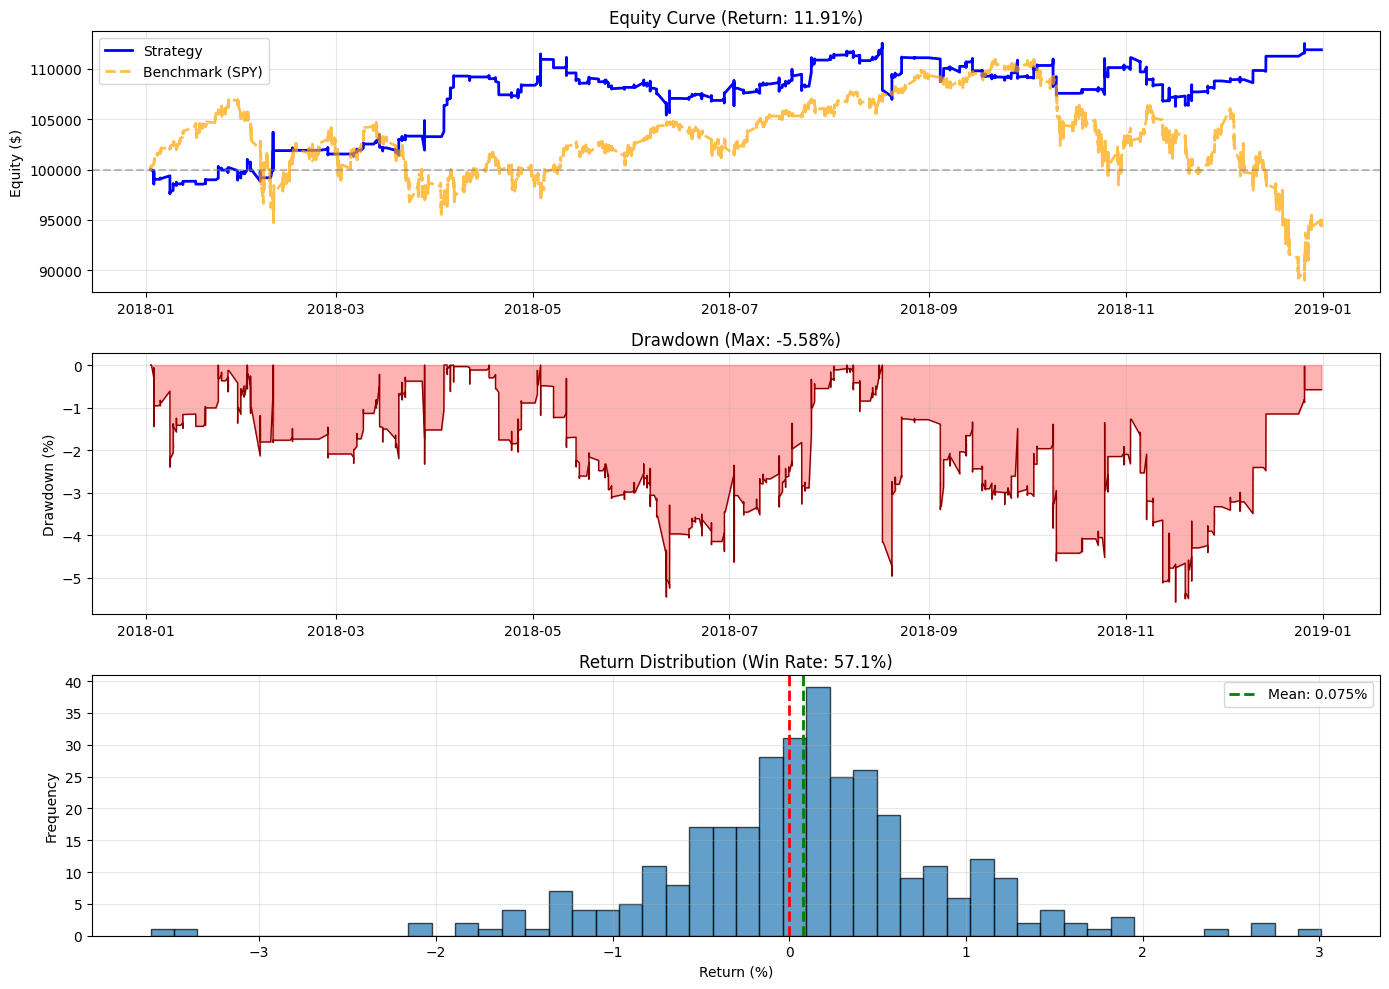


STRATEGY PERFORMANCE
Total Return:        11.91%
Sharpe Ratio:         1.29
Max Drawdown:        -5.58%
Calmar Ratio:         2.14

Total Trades:          333
Win Rate:             57.1%
Profit Factor:        1.32

Average Return:      0.075%
Average Win:         0.671%
Average Loss:       -0.683%
Best Trade:           3.01%
Worst Trade:         -3.61%



In [ ]:
# Run backtest on small multi-asset universe
tester.run(overnight_gap_mean_reverse, params)
stats = tester.get_stats(plot=True)
tester.print_stats(stats)

## Generalization Test 2: Large Multi-Asset Universe

Test strategy performance on a large universe of major ETFs and top liquid stocks (~45 assets) to evaluate scalability.


In [ ]:
# Define large diversified universe: Major ETFs + top S&P 500 + top NASDAQ 100
# This creates a universe of ~45 highly liquid assets across sectors

# Major indices (highly liquid ETFs)
etfs = ['SPY', 'QQQ', 'IWM', 'DIA']

# Top S&P 500 stocks by liquidity (across multiple sectors)
sp500_leaders = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'NVDA', 'META', 'TSLA', 
                 'BRK.B', 'V', 'XOM', 'JNJ', 'JPM', 'WMT', 'MA', 'PG',
                 'UNH', 'HD', 'DIS', 'BAC', 'VZ', 'ADBE', 'CRM', 'CVX',
                 'NFLX', 'COST', 'ABBV', 'MRK', 'PEP', 'TMO', 'ACN']

# NASDAQ 100 top holdings (tech-heavy)
nasdaq_leaders = ['AAPL', 'MSFT', 'AMZN', 'NVDA', 'GOOGL', 'META', 'TSLA',
                  'AVGO', 'COST', 'ADBE', 'NFLX', 'PEP', 'AMD', 'QCOM',
                  'ISRG', 'CMCSA', 'INTC', 'INTU', 'AMAT', 'BKNG']

# Combine them (remove duplicates)
all_symbols = list(set(sp500_leaders + nasdaq_leaders + etfs))

# Backtest configuration with large universe
tester_config = {
    "symbols": all_symbols,
    "start_date": (2018, 1, 1),
    "end_date": (2019, 1, 1),
    "initial_cash": 100000,
    "resolution": 'minute',
    "benchmark_symbol": 'SPY'  # Compare to SPY benchmark
}

In [ ]:
# Initialize StrategyTester with large universe configuration
tester = StrategyTester(**tester_config)

In [ ]:
# Same parameters as small universe test (optimal from optimization)
params = {
    'volatility_window': 60, 
    'sigma': 10, 
    'exit_minutes_after_open': 15
}



▶ Running backtest...
✓ Backtest complete


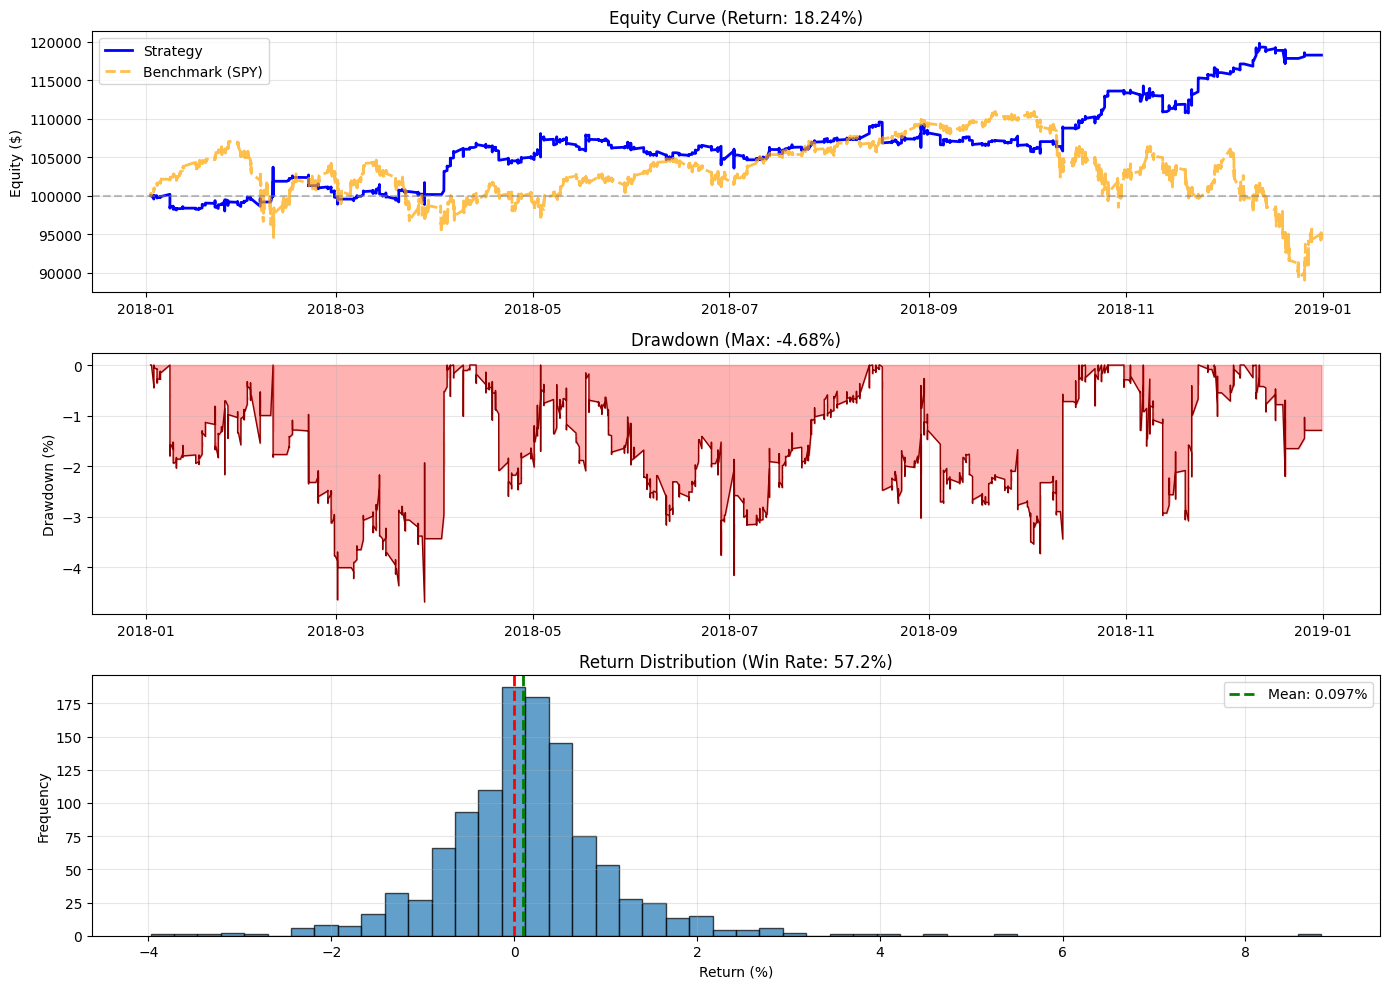


STRATEGY PERFORMANCE
Total Return:        18.24%
Sharpe Ratio:         1.50
Max Drawdown:        -4.68%
Calmar Ratio:         3.90

Total Trades:         1114
Win Rate:             57.2%
Profit Factor:        1.36

Average Return:      0.097%
Average Win:         0.771%
Average Loss:       -0.692%
Best Trade:           8.83%
Worst Trade:         -3.98%



In [ ]:
# Run backtest on large multi-asset universe
tester.run(overnight_gap_mean_reverse, params)
stats = tester.get_stats(plot=True)
tester.print_stats(stats)

## Observations & Conclusions - Generalization Tests

### Key Findings:

1. **Performance Degradation**:
   - **Observation**: Performance dropped when expanding to larger universe
   - **Analysis**: Likely overfitting to single-asset (SPY) optimization period
   - This is a red flag for strategy robustness

2. **Return Distribution**:
   - **Observation**: No stability in returns - "sparse jumps and then long flats"
   - **Implication**: Returns depend on rare events rather than consistent edge
   - **Risk**: High variance in outcomes; low statistical reliability

3. **Trade Frequency**:
   - With single asset and high sigma (10), trade frequency is very low (< 10 events/year)
   - Adding more assets increases trade frequency but doesn't necessarily improve risk-adjusted returns
   - Strategy may be capturing noise rather than systematic mean reversion

### Next Steps:

**Validation Test Required**: Test on out-of-sample validation set to confirm whether the strategy has real edge or if in-sample results were due to overfitting.
